In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(color_codes=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.10.1


## Load the data

In [3]:
df = pd.read_csv('../cleaned_data/ISAT.csv', index_col='Date', parse_dates=True)
df.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
Date,,,,,,,,,,,,,,,,,,
2012-10-17,0.437800,0.340388,0.341359,0.526150,0.750237,0.216300,0.113942,0.235652,0.709952,0.010976,0.0,0.5,0.5,-1.0,0.594005,0.066667,0.592593,0.482270
2012-10-18,0.460510,0.358130,0.342201,-0.036486,0.560174,0.121030,0.039230,0.163048,0.609002,0.051422,0.5,0.5,0.5,-1.0,0.599455,0.133333,0.592593,0.464539
2012-10-19,0.465556,0.374604,0.342201,-0.021718,0.560174,0.121030,0.039230,-0.331469,0.646230,0.158623,1.0,0.5,0.5,-1.0,0.604905,0.200000,0.592593,0.464539
2012-10-22,0.463033,0.394880,0.348093,-0.106151,0.884145,0.391605,0.265115,0.014964,0.619132,0.610507,-1.0,0.5,0.5,-1.0,0.621253,0.400000,0.629630,0.517730
2012-10-23,0.473126,0.415157,0.362404,0.241153,0.659316,0.282592,0.182832,0.236528,0.608329,0.870434,-0.5,0.5,0.5,-1.0,0.626703,0.466667,0.629630,0.500000


### Plot the Close price - our target

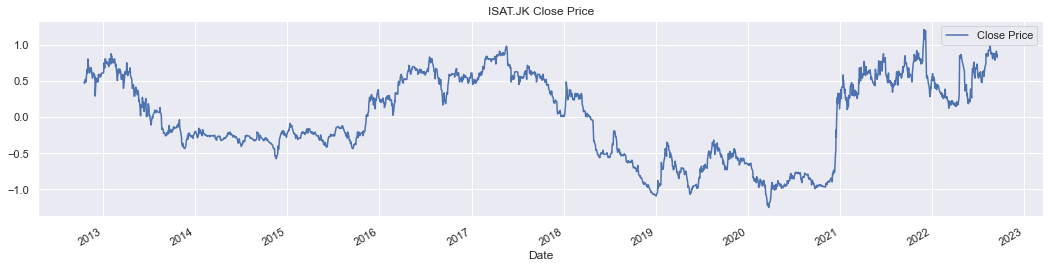

In [4]:
df['Close'].plot(figsize=(18, 4))
plt.legend(['Close Price'])
plt.title('ISAT.JK Close Price')
plt.show()

### Split the data
- Split the data into independent variables and target variable
- Split the data into train and test set (80:20)

In [5]:
train_len = int(len(df)*.8)
train_dataset = df[:train_len]
test_dataset = df[train_len:len(df)]

In [6]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Close')
test_labels = test_features.pop('Close')

## Modeling

### Regression with Deep Neural Network

In [7]:
from utils import build_and_compile_model, fit_model

In [8]:
from utils import genPredictions, inversePredsAndAct, evaluateModel

In [9]:
from joblib import load

close_scaler = load('../feature_engineering/isat_close_scaler.bin')

In [10]:
epochs_cands = [100,150,200]
batch_size_cands = [32,64,128]
performances = {}
models = {}
predictions_dfs = {}
inversed_dfs = {}

modelID = 1
for epochs in epochs_cands:
    for batch_size in batch_size_cands:
        print(f'\n==========MODEL {modelID} with epochs: {epochs} and batch size: {batch_size}==========')
        model = build_and_compile_model(17)
        history = fit_model(model, epochs, batch_size, train_features, train_labels)
        models[f'Model-{modelID}'] = (model, history)
        predictions = genPredictions(model, df, test_features, train_len)
        predictions_dfs[f'Model-{modelID}'] = predictions
        
        inversed = inversePredsAndAct(predictions, close_scaler, test_labels)
        inversed_dfs[f'Model-{modelID}'] = inversed
        rmse_, mape_, rsquared_ = evaluateModel(inversed)
        performances[f'Model-{modelID}'] = {
            'Epochs': epochs,
            'Batch Size': batch_size,
            'RMSE': rmse_,
            'MAPE': mape_,
            'R2': rsquared_
        }
        
        modelID += 1
        


==========MODEL 1 with epochs: 100 and batch size: 32==========
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1152      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
None
16/16 [==============================] - 0s 2ms/step

==========MODEL 2 with epochs: 100 and batch size: 64==========
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape 

Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
None
16/16 [==============================] - 0s 1ms/step


In [11]:
performance_df = pd.DataFrame(performances).transpose()
performance_df[['Epochs', 'Batch Size']] = performance_df[['Epochs', 'Batch Size']].astype(int)
performance_df.head(9)

,Epochs,Batch Size,RMSE,MAPE,R2
Model-1,100,32,271.365813,3.775753,0.967451
Model-2,100,64,302.688073,4.634194,0.959503
Model-3,100,128,287.548144,3.796037,0.963453
Model-4,150,32,273.907539,4.242956,0.966838
Model-5,150,64,300.421533,4.895901,0.960108
Model-6,150,128,291.186036,4.392860,0.962523
Model-7,200,32,295.912869,4.296596,0.961296
Model-8,200,64,318.116005,4.748882,0.955270
Model-9,200,128,270.932155,4.448819,0.967555


### Plot the best model

In [12]:
from utils import plotPredAct, plotErrorHist

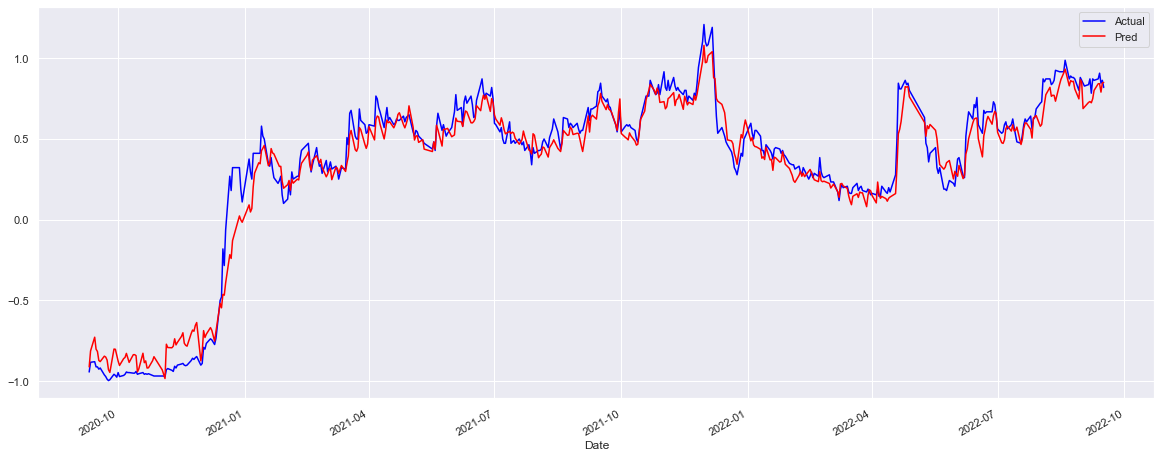

In [13]:
plotPredAct(predictions_dfs['Model-9'])

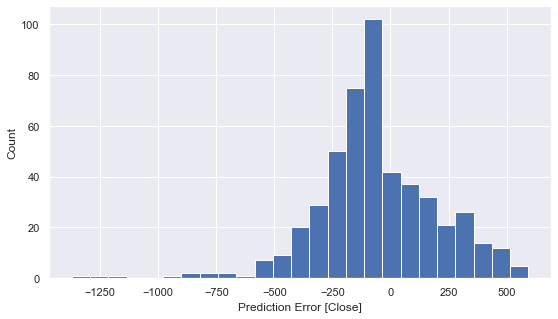

In [14]:
plt.figure(figsize=(9,5))
plotErrorHist(inversed_dfs['Model-9'])

### Save the best model

In [15]:
models['Model-9'][0].save('./models/isat.h5')

In [16]:
loadedModel = keras.models.load_model('./models/isat.h5')

In [17]:
loadedModel.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                1152      
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
